In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller


In [16]:
# Load price data
ticker1 = 'KO'
ticker2 = 'PEP'

prices = pd.read_csv('../data_raw/ko_pep_prices.csv', index_col=0, parse_dates=True).dropna()
price1 = prices[ticker1].values
price2 = prices[ticker2].values

print(f"Data points: {len(price1)}")
print(f"Date range: {prices.index[0].date()} to {prices.index[-1].date()}")

Data points: 1508
Date range: 2020-01-02 to 2025-12-31


## 1. Validate Trading Strategy Hypothesis

Before feature engineering, we'll verify:
- **Hurst Exponent**: Prove mean reversion behavior
- **Cointegration**: Prove long-run equilibrium relationship
- **Correlation**: Prove the stocks move together

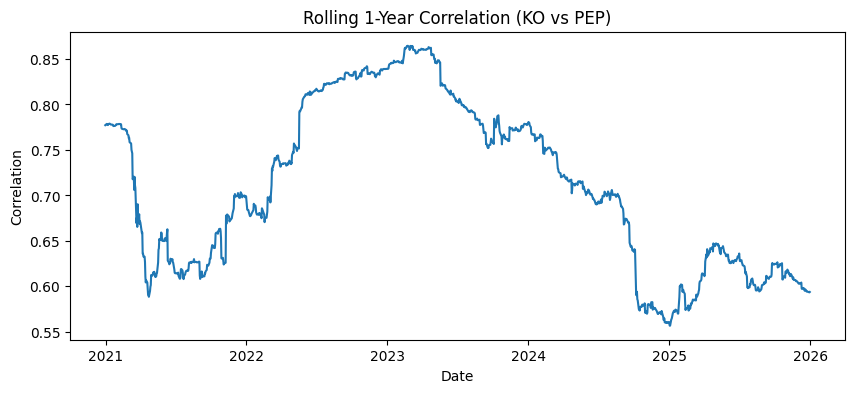

Overall correlation (KO vs PEP): 0.7320
The rolling window used is 252 days.
Data points: 1508
Date range: 2020-01-02 to 2025-12-31


In [17]:
# First we compute the correlation
# Log returns:
returns = np.log(prices).diff().dropna()
return1 = returns[ticker1].to_numpy()
return2 = returns[ticker2].to_numpy()
dates = returns.index

def rolling_correlation(x, y, window):
    n = len(x)
    output = np.full(n, np.nan, dtype=float)
    
    for i in range(window - 1, n):
        x_window = x[i - window + 1:i + 1]
        y_window = y[i - window + 1:i + 1]
        
        x_mean = np.mean(x_window)
        y_mean = np.mean(y_window)
        
        dx = x_window - x_mean
        dy = y_window - y_mean
        
        covarience = np.dot(dx, dy)/(window - 1)
        std_x = np.std(x_window, ddof=1)
        std_y = np.std(y_window, ddof=1)
        if (std_x > 0 and std_y > 0):
            output[i] = covarience / (std_x * std_y)
        else:
            output[i] = np.nan
    
    return output

window = 252
data_rolling_correlation = rolling_correlation(return1, return2, window)
rolling_corr_series = pd.Series(data_rolling_correlation, index=dates, name="rolling_corr_252d")
rolling_corr_series.tail()

# Plotting the data of correlation
plt.figure(figsize=(10, 4))
plt.plot(rolling_corr_series.index, rolling_corr_series.values)
plt.title("Rolling 1-Year Correlation (KO vs PEP)")
plt.xlabel("Date")
plt.ylabel("Correlation")
plt.show()

# Compute the overall correlation
def overall_correlation(x, y):
    n = len(x)
    
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    
    dx = x - x_mean
    dy = y - y_mean

    covariance = np.dot(dx, dy)/(n - 1)
    std_x = np.std(x, ddof=1)
    std_y = np.std(y, ddof=1)
    if (std_x > 0 and std_y > 0):
        return covariance / (std_x * std_y)
    else:
        return np.nan

corr = overall_correlation(return1, return2)
print(f"Overall correlation (KO vs PEP): {corr:.4f}")
print(f"The rolling window used is {window} days.")
print(f"Data points: {len(price1)}")
print(f"Date range: {prices.index[0].date()} to {prices.index[-1].date()}")


### 1.2 Cointegration Test
Tests if stocks have a long-run equilibrium relationship (essential for pairs trading)

<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>
1508 1508 (1508, 2)
True


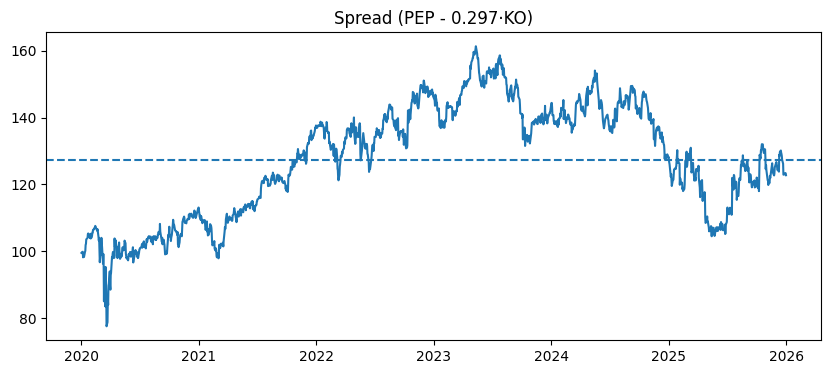

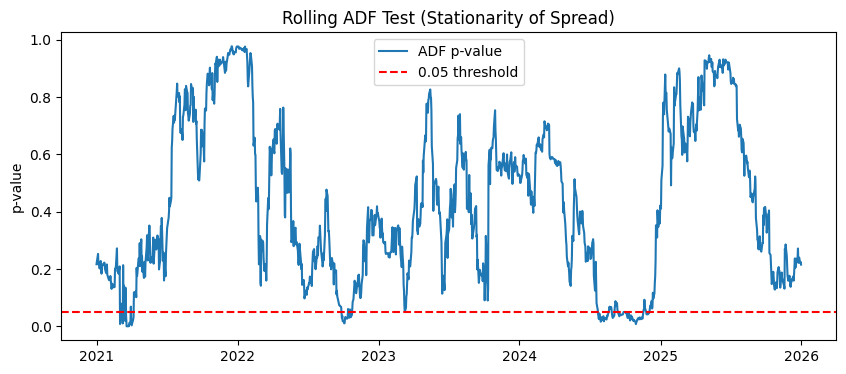

In [18]:
# Then we compute the Cointegration test


# keep only these two columns, then drop rows where either is missing
prices = prices[[ticker1, ticker2]].dropna()

# 2) Keep as pandas Series (important)
price1 = prices[ticker1]
price2 = prices[ticker2]

# sanity checks (run these!)
print(type(price1), type(price2))
print(len(price1), len(price2), prices.shape)
print(price1.index.equals(price2.index))  # should be True

def hedge_ratio(x, y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    covariance = np.dot(x - x_mean, y - y_mean) / (len(x) - 1)
    variance = ((x - x_mean) ** 2).sum()/(len(x) - 1)
    return covariance / variance

beta = hedge_ratio(price2, price1)
spread = price2 - beta * price1  # this is a pandas Series with the same index as prices

plt.figure(figsize=(10,4))
plt.plot(spread.index, spread.values)
plt.axhline(spread.mean(), linestyle="--")
plt.title(f"Spread ({ticker2} - {beta:.3f}·{ticker1})")
plt.show()

rolling_pvals = []

for i in range(window, len(spread)):
    spread_window = spread.iloc[i-window:i]
    pval = adfuller(spread_window)[1]
    rolling_pvals.append(pval)

rolling_pvals = pd.Series(
    rolling_pvals,
    index=spread.index[window:]
)

plt.figure(figsize=(10,4))
plt.plot(rolling_pvals.index, rolling_pvals.values, label="ADF p-value")
plt.axhline(0.05, color="red", linestyle="--", label="0.05 threshold")
plt.title("Rolling ADF Test (Stationarity of Spread)")
plt.ylabel("p-value")
plt.legend()
plt.show()



---

## 2. Feature Engineering

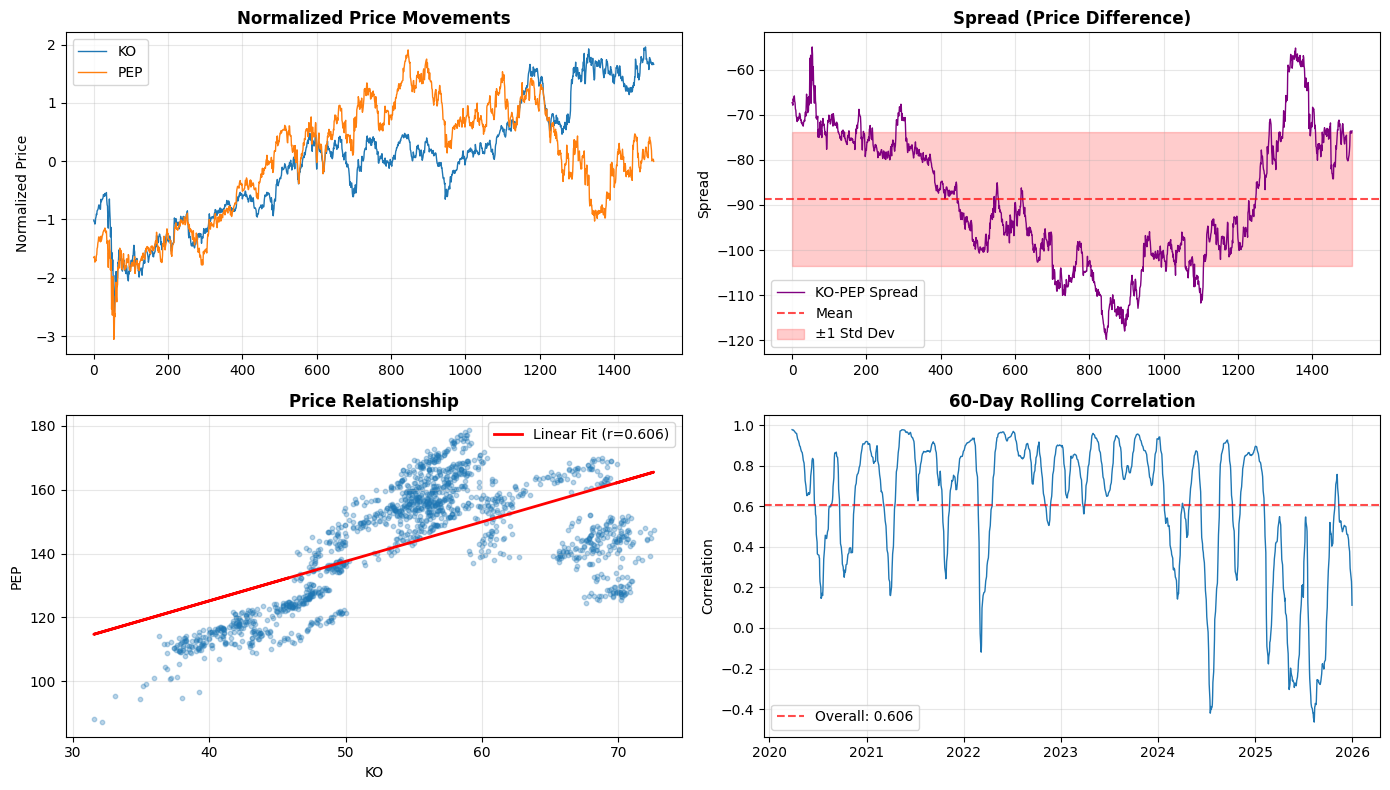

CORRELATION ANALYSIS
Pearson Correlation: 0.6063

Interpretation:
  |r| > 0.7  → Strong relationship
  0.5-0.7    → Moderate relationship
  < 0.5      → Weak relationship

⚠ WARNING: Consider correlation strength


In [6]:
# Correlation analysis
correlation = np.corrcoef(price1, price2)[0, 1]

# Plot price movements
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Plot 1: Normalized prices
ax1 = axes[0, 0]
ax1.plot((price1 - price1.mean()) / price1.std(), label=ticker1, linewidth=1)
ax1.plot((price2 - price2.mean()) / price2.std(), label=ticker2, linewidth=1)
ax1.set_title('Normalized Price Movements', fontsize=12, fontweight='bold')
ax1.set_ylabel('Normalized Price')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Spread
ax2 = axes[0, 1]
ax2.plot(spread, label=f'{ticker1}-{ticker2} Spread', color='purple', linewidth=1)
ax2.axhline(spread.mean(), color='red', linestyle='--', label='Mean', alpha=0.7)
ax2.fill_between(range(len(spread)), spread.mean() - spread.std(), spread.mean() + spread.std(), 
                  alpha=0.2, color='red', label='±1 Std Dev')
ax2.set_title('Spread (Price Difference)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Spread')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Scatter plot
ax3 = axes[1, 0]
ax3.scatter(price1, price2, alpha=0.3, s=10)
z = np.polyfit(price1, price2, 1)
p = np.poly1d(z)
ax3.plot(price1, p(price1), "r-", label=f'Linear Fit (r={correlation:.3f})', linewidth=2)
ax3.set_xlabel(ticker1)
ax3.set_ylabel(ticker2)
ax3.set_title('Price Relationship', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Rolling correlation
ax4 = axes[1, 1]
rolling_corr = pd.Series(price1, index=prices.index).rolling(60).corr(pd.Series(price2, index=prices.index))
ax4.plot(rolling_corr, linewidth=1)
ax4.axhline(correlation, color='red', linestyle='--', label=f'Overall: {correlation:.3f}', alpha=0.7)
ax4.set_title('60-Day Rolling Correlation', fontsize=12, fontweight='bold')
ax4.set_ylabel('Correlation')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("=" * 50)
print("CORRELATION ANALYSIS")
print("=" * 50)
print(f"Pearson Correlation: {correlation:.4f}")
print(f"\nInterpretation:")
print(f"  |r| > 0.7  → Strong relationship")
print(f"  0.5-0.7    → Moderate relationship")
print(f"  < 0.5      → Weak relationship")
print(f"\n{'✓ SUCCESS' if abs(correlation) > 0.7 else '⚠ WARNING'}: {abs(correlation) > 0.7 and 'Stocks are highly correlated' or 'Consider correlation strength'}")
print("=" * 50)

### 1.2 Correlation Analysis

In [5]:
# Calculate spread
spread = price1 - price2

# Calculate Hurst Exponent for spread
hurst_spread = calculate_hurst_exponent(spread)

# Calculate Hurst for individual stocks (for reference)
hurst_ko = calculate_hurst_exponent(price1)
hurst_pep = calculate_hurst_exponent(price2)

print("=" * 50)
print("HURST EXPONENT ANALYSIS (Mean Reversion Test)")
print("=" * 50)
print(f"\nInterpretation:")
print(f"  H < 0.5 → Mean Reverting (GOOD for pairs trading)")
print(f"  H = 0.5 → Random Walk")
print(f"  H > 0.5 → Trending (BAD for mean reversion)")
print(f"\nResults:")
print(f"  {ticker1} alone:        H = {hurst_ko:.4f} {'✓ Mean Reverting' if hurst_ko < 0.5 else '✗ Trending'}")
print(f"  {ticker2} alone:        H = {hurst_pep:.4f} {'✓ Mean Reverting' if hurst_pep < 0.5 else '✗ Trending'}")
print(f"  {ticker1}-{ticker2} Spread: H = {hurst_spread:.4f} {'✓ Mean Reverting' if hurst_spread < 0.5 else '✗ Trending'}")
print(f"\n{'✓ SUCCESS' if hurst_spread < 0.5 else '✗ CONCERN'}: Spread shows {'mean reversion' if hurst_spread < 0.5 else 'trending'} behavior")
print("=" * 50)

HURST EXPONENT ANALYSIS (Mean Reversion Test)

Interpretation:
  H < 0.5 → Mean Reverting (GOOD for pairs trading)
  H = 0.5 → Random Walk
  H > 0.5 → Trending (BAD for mean reversion)

Results:
  KO alone:        H = 0.4103 ✓ Mean Reverting
  PEP alone:        H = 0.5669 ✗ Trending
  KO-PEP Spread: H = 0.5157 ✗ Trending

✗ CONCERN: Spread shows trending behavior


### 1.1 Hurst Exponent Analysis
Mean reversion hypothesis: Hurst < 0.5

In [ ]:
# Load price data
ticker1 = 'KO'
ticker2 = 'PEP'

price1 = prices[ticker1].values
price2 = prices[ticker2].values

print(f"Data points: {len(price1)}")
print(f"Date range: {prices.index[0].date()} to {prices.index[-1].date()}")

Data points: 1508
Date range: 2020-01-02 to 2025-12-31


In [4]:
# Helper function to calculate Hurst Exponent
def calculate_hurst_exponent(time_series, lags_range=None):
    """
    Calculate Hurst Exponent to detect mean reversion (H < 0.5) vs trending (H > 0.5)
    
    H < 0.5: Mean reverting (good for pairs trading)
    H = 0.5: Random walk
    H > 0.5: Trending
    """
    if lags_range is None:
        lags_range = range(10, min(len(time_series)//2, 500))
    
    tau = []
    for lag in lags_range:
        # Calculate rescaled range
        diffs = np.diff(time_series, lag)
        mean_centered = time_series - np.mean(time_series)
        Y = np.cumsum(mean_centered)
        R = np.max(Y[:lag*(len(time_series)//lag)].reshape(-1, lag), axis=1) - \
            np.min(Y[:lag*(len(time_series)//lag)].reshape(-1, lag), axis=1)
        S = np.std(time_series[:lag*(len(time_series)//lag)].reshape(-1, lag), axis=1)
        tau.append(np.mean(R/S))
    
    poly = np.polyfit(np.log(list(lags_range)), np.log(tau), 1)
    hurst = poly[0]
    return hurst

In [8]:
# Calculate and engineer features from the spread
spread_series = pd.Series(spread, index=prices.index)

# Z-score with 20-day window
rolling_mean = spread_series.rolling(window=20).mean()
rolling_std = spread_series.rolling(window=20).std()
zscore = (spread_series - rolling_mean) / rolling_std

# Create features dataframe
features = pd.DataFrame(index=prices.index)
features['spread'] = spread_series
features['zscore'] = zscore
features['rolling_mean'] = rolling_mean
features['rolling_std'] = rolling_std
features['rolling_min'] = spread_series.rolling(window=20).min()
features['rolling_max'] = spread_series.rolling(window=20).max()

# Remove NaN rows
features = features.dropna()

print(f"Features shape: {features.shape}")
print(f"\nFeatures (first 5 rows):")
print(features.head())
print(f"\nFeatures summary:")
print(features.describe())

Features shape: (1489, 6)

Features (first 5 rows):
               spread    zscore  rolling_mean  rolling_std  rolling_min  \
Date                                                                      
2020-01-30 -70.820446 -0.953485    -68.926335     1.986514    -71.52737   
2020-01-31 -69.695705 -0.333445    -69.042674     1.958440    -71.52737   
2020-02-03 -69.954044 -0.407271    -69.167364     1.931591    -71.52737   
2020-02-04 -70.329075 -0.540810    -69.288321     1.924437    -71.52737   
2020-02-05 -71.220158 -0.915747    -69.525474     1.850602    -71.52737   

            rolling_max  
Date                     
2020-01-30    -65.84536  
2020-01-31    -65.84536  
2020-02-03    -65.84536  
2020-02-04    -65.84536  
2020-02-05    -65.84536  

Features summary:
            spread       zscore  rolling_mean  rolling_std  rolling_min  \
count  1489.000000  1489.000000   1489.000000  1489.000000  1489.000000   
mean    -88.954216    -0.093847    -88.913509     2.095345   -92.382651

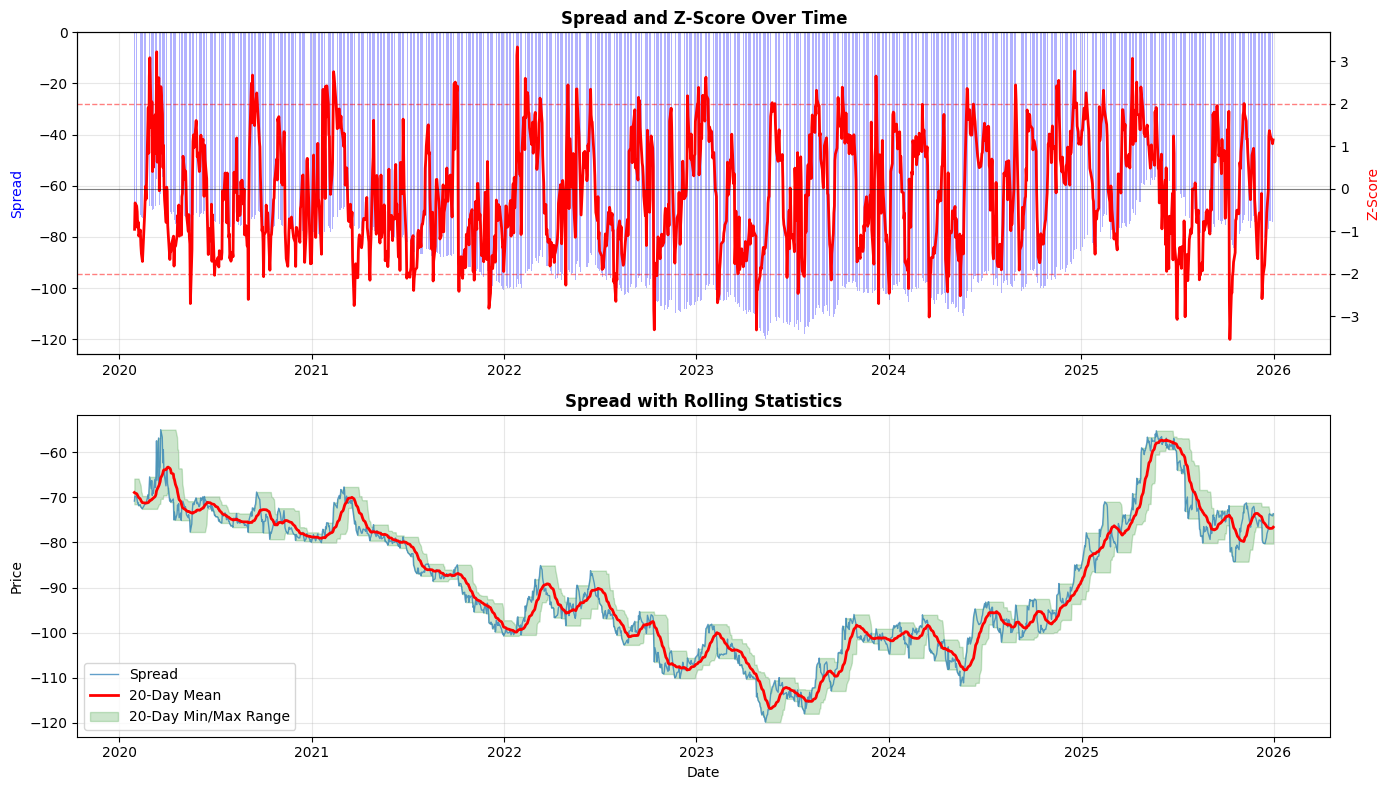

In [9]:
# Visualize engineered features
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Plot 1: Spread with Z-score
ax1 = axes[0]
ax1_twin = ax1.twinx()
ax1.bar(features.index, features['spread'], alpha=0.3, label='Spread', color='blue')
ax1_twin.plot(features.index, features['zscore'], color='red', linewidth=2, label='Z-Score')
ax1_twin.axhline(0, color='black', linestyle='-', linewidth=0.8, alpha=0.5)
ax1_twin.axhline(2, color='red', linestyle='--', linewidth=1, alpha=0.5, label='±2σ Threshold')
ax1_twin.axhline(-2, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax1.set_ylabel('Spread', color='blue')
ax1_twin.set_ylabel('Z-Score', color='red')
ax1.set_title('Spread and Z-Score Over Time', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Plot 2: Rolling statistics
ax2 = axes[1]
ax2.plot(features.index, features['spread'], label='Spread', linewidth=1, alpha=0.7)
ax2.plot(features.index, features['rolling_mean'], label='20-Day Mean', linewidth=2, color='red')
ax2.fill_between(features.index, features['rolling_min'], features['rolling_max'], 
                  alpha=0.2, color='green', label='20-Day Min/Max Range')
ax2.set_ylabel('Price')
ax2.set_xlabel('Date')
ax2.set_title('Spread with Rolling Statistics', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [10]:
# Save features to CSV
features.to_csv('../data_processed/features_KO_PEP.csv')
print(f"✓ Saved {len(features)} feature rows to: data_processed/features_KO_PEP.csv")

✓ Saved 1489 feature rows to: data_processed/features_KO_PEP.csv
